# Getting started with APIs in Python

using the [client credentials flow](https://developer.spotify.com/documentation/general/guides/authorization-guide/) to interact with spotify and learn the ins and outs of working with third party APIs

## Initial Setup:
- import `requests` so we can hit up our endpoints
- import our client's id and secret values that we were given when we created the app with spotify
- define some additional content that we're going to be working with

In [3]:
import requests
from secrets import client_id, client_secret

track_id = '6y0igZArWVi6Iz0rj35c1Y'
base_endpoint = 'http://api.spotify.com/v1/'
auth_url = 'https://accounts.spotify.com/api/token'

## Getting Authorisation
the first thing we need to do is acquire an access token from spotify using our client id and client secret. this takes the form of a post request to an authorisation URL and a json formatted payload. 

In [4]:
auth_response = requests.post(auth_url, {
    'grant_type': 'client_credentials',
    'client_id': client_id,
    'client_secret': client_secret,
})

now that we have a response from spotify we can convert the received data to json and access its KVPs, most importantly the access token that'll allow us to make further requests.

In [5]:
auth_response_data = auth_response.json()
access_token = auth_response_data['access_token']

The variable `auth_response_data` is a json object comprising the following information:

```json
{
    'access_token': 'a big long string of numbers and letters',
    'token_type': 'Bearer',
    'expires_in': 3600
}
```
having the data as a json object means we can access the KVP contents using `[]` indexing.


## Accessing Spotify Data

Now that we have authorisation we can start formulating queries in order to acquire meaningful data. first, we need some header information. refer to the spotify documentation for how to format headers in order to make successful requests.

In [6]:
headers = {
    'Authorization':'Bearer {token}'.format(token=access_token)
}

Outlining the header here means we don't need to muck about with formatting json inside our next get request. Think of the header as the password you need in order to access the system.

Spotify's going to expect endpoint requests to follow a specific configuration. This example will allow us to request a track's [audio features](https://developer.spotify.com/console/get-audio-features-track/).

The next request is sent using the GET verb, which uses the URL as a means to transfer information from us to Spotify. The previous request was sent using POST, meaning the credentials were carried in the message body itself and it therefore more secure. 

### Sidenote: HTTP Body Data

HTTP Body Data is the data bytes transmitted in an HTTP transaction message immediately following the headers if there is any (in the case of HTTP/0.9 no headers are transmitted).

Most HTTP requests are GET requests without bodies. However, simulating requests with bodies is important to properly stress the proxy code and to test various hooks working with such requests. Most HTTP requests with bodies use POST or PUT request method.

**Message Body**

The message body part is optional for an HTTP message but if it is available then it is used to carry the entity-body associated with the request or response. If entity body is associated then usually Content-Type and Content-Length headers lines specify the nature of the body associated.

A message body is the one which carries actual HTTP request data (including form data and uploaded etc.) and HTTP response data from the server ( including files, images etc). Following is a simple content of a message body:

```html
<html>
<body>
<h1>Hello, World!</h1>
</body>
</html>
```

For more details to HTTP messages and bodies refer to [w3org link](http://www.w3.org/Protocols/rfc2616/rfc2616-sec4.html)

In [7]:
response = requests.get(
    base_endpoint + 'audio-features/' + track_id, headers=headers
)

response_data = response.json()
print(response_data)

{'danceability': 0.54, 'energy': 0.59, 'key': 0, 'loudness': -4.359, 'mode': 1, 'speechiness': 0.0528, 'acousticness': 0.446, 'instrumentalness': 0, 'liveness': 0.14, 'valence': 0.267, 'tempo': 119.878, 'type': 'audio_features', 'id': '6y0igZArWVi6Iz0rj35c1Y', 'uri': 'spotify:track:6y0igZArWVi6Iz0rj35c1Y', 'track_href': 'https://api.spotify.com/v1/tracks/6y0igZArWVi6Iz0rj35c1Y', 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/6y0igZArWVi6Iz0rj35c1Y', 'duration_ms': 234910, 'time_signature': 4}


As before, we get back a load of json, this time it's a load of information relating to the track we fed the endpoint

```json
{
  "danceability": 0.54,
  "energy": 0.59,
  "key": 0,
  "loudness": -4.359,
  "mode": 1,
  "speechiness": 0.0528,
  "acousticness": 0.446,
  "instrumentalness": 0,
  "liveness": 0.14,
  "valence": 0.267,
  "tempo": 119.878,
  "type": "audio_features",
  "id": "6y0igZArWVi6Iz0rj35c1Y",
  "uri": "spotify:track:6y0igZArWVi6Iz0rj35c1Y",
  "track_href": "https://api.spotify.com/v1/tracks/6y0igZArWVi6Iz0rj35c1Y",
  "analysis_url": "https://api.spotify.com/v1/audio-analysis/6y0igZArWVi6Iz0rj35c1Y",
  "duration_ms": 234910,
  "time_signature": 4
}
```

the Spotify API docs give detailed explanations of the [meanings of each of these values](https://developer.spotify.com/documentation/web-api/reference/#endpoint-get-audio-features). Again, because this is all json formatted it's ripe for mucking about with, extracting the KVPs using index notation, e.g:

In [8]:
track_danceability = response_data['danceability']
print(track_danceability)   # => 0.54

0.54


## Putting it all together
Now that we have access to all this data we can do things like punt it all into a pandas dataframe and muck about with it. We can access Autechre's discography using a similar request to before, but we need to change our endpoint given we want a frame of albums. The song endpoint won't work in this case.

In [9]:
artist_id = '6WH1V41LwGDGmlPUhSZLHO'

artist_request = requests.get(base_endpoint + 'artists/' + artist_id + '/albums', headers=headers,
                       params={'include-groups': 'album', 'limit': 50})
artist_response = artist_request.json()
# print(artist_response)
    # trust me, it's a _lot_ of data


In [10]:
artist_response['items'][0]


{'album_group': 'album',
 'album_type': 'album',
 'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/6WH1V41LwGDGmlPUhSZLHO'},
   'href': 'https://api.spotify.com/v1/artists/6WH1V41LwGDGmlPUhSZLHO',
   'id': '6WH1V41LwGDGmlPUhSZLHO',
   'name': 'Autechre',
   'type': 'artist',
   'uri': 'spotify:artist:6WH1V41LwGDGmlPUhSZLHO'}],
 'available_markets': ['JP'],
 'external_urls': {'spotify': 'https://open.spotify.com/album/02BlC7Td9LszbLCSUhysgZ'},
 'href': 'https://api.spotify.com/v1/albums/02BlC7Td9LszbLCSUhysgZ',
 'id': '02BlC7Td9LszbLCSUhysgZ',
 'images': [{'height': 640,
   'url': 'https://i.scdn.co/image/ab67616d0000b273aebc9831860082ed6db15791',
   'width': 640},
  {'height': 300,
   'url': 'https://i.scdn.co/image/ab67616d00001e02aebc9831860082ed6db15791',
   'width': 300},
  {'height': 64,
   'url': 'https://i.scdn.co/image/ab67616d00004851aebc9831860082ed6db15791',
   'width': 64}],
 'name': 'PLUS',
 'release_date': '2020-10-29',
 'release_date_precision':

In [11]:
for album in artist_response['items']:
    print(album['name'], ' - ', album['release_date'])

PLUS  -  2020-10-29
PLUS  -  2020-10-28
SIGN  -  2020-10-16
SIGN  -  2020-10-16
NTS Session 4  -  2018-08-26
NTS Session 3  -  2018-08-25
NTS Session 2  -  2018-08-24
NTS Session 2  -  2018-08-24
NTS Session 3  -  2018-08-24
NTS Session 4  -  2018-08-24
NTS Session 1  -  2018-08-09
NTS Session 1  -  2018-08-09
elseq 1  -  2016-09-23
elseq  -  2016-05-20
elseq 1  -  2016-05-20
elseq 2  -  2016-05-20
elseq 2  -  2016-05-20
elseq 3  -  2016-05-20
elseq 3  -  2016-05-20
elseq 4  -  2016-05-20
elseq 4  -  2016-05-20
elseq 5  -  2016-05-20
elseq 5  -  2016-05-20
Exai  -  2013-03-04
Exai  -  2013-02-04
Move Of Ten  -  2010-07-12
Oversteps  -  2010-03-22
Oversteps  -  2010-02-22
Quaristice  -  2008
Quaristice  -  2007
Untilted  -  2005-04-18
Untilted  -  2005-04-18
Draft 7.30  -  2003-04-07
Draft 7.30  -  2003-04-07
Confield  -  2001-04-30
Confield  -  2001-04-30
EP7  -  1999-06-07
LP5  -  1998-07-13
LP5  -  1998
Chiastic Slide  -  1997-02-17
Envane  -  1997-01-27
Envane  -  1997-01-27
Chiasti

## Cleaning things up

Now that we have each of Autechre's albums we can use that list to pull all the tracks. Not only that, but we can use Pandas to store all this data in a DataFrame object and clean things up from there. 

The next code snippet scans through our list of albums and only adds those which aren't already in the list. Once that's done we can hit up the tracks endpoint and pull down the data for each track on the album we're currently processing. The flow here is:
1. ascertain the album is unique then add it to the list of albums
2. scan that album for all its tracks, grab the data for each track
3. combine each track with its album data in a single json object (dictionary?)
4. append the dictionary to the list of `data`

In [12]:
data = []       # will eventually end up as a dataframe
albums = []     # a a collection of unique albums (this could habe been a set?)

for album in artist_response['items']:
    album_name = album['name'].upper()
    
    if album_name in albums:
        continue
    else:
        albums.append(album_name)
    
    print(album_name)
    
    # hitting up the tracks endpoint and pulling down the track data for each album
    request = requests.get(base_endpoint + 'albums/' + album['id'] + '/tracks', headers=headers)
    tracks = request.json()['items']
    
    for track in tracks:
        # grabbing the audio features from each track
        f = requests.get(base_endpoint + 'audio-features/' + track['id'], headers=headers)
        f = f.json()
        
        # combining track geatures with album info
        f.update({
            'track_name': track['name'],
            'album_name': album_name,
            'release_date': album['release_date'],
            'album_id': album['id']
        })
        
        data.append(f)

PLUS
SIGN


Now that we've got `data`, our list of dictionaries, we can import pandas and cast it to a DataFrame object

In [ ]:
import pandas as pd
data = pd.DataFrame(data)

Having everything in a DataFrame makes it nice and easy to clean up given Pandas' toolset.

In [ ]:
data['release_date'] = pd.to_datetime(data['release_date'])
df = data.sort_values(by='release_date', ascending=[False])

## Visualising the Data

We can use [Matplotlib](https://matplotlib.org/) and [Seaborn](https://seaborn.pydata.org/) to visualise our data. In this instance we're creating a scattergraph comparing an album's 'acousticness' to its 'valence', the extent to which an album is emotionally positive or negative. We can create a figure using Matplotlib, and then a coloured scattergraph of using Seaborn. 

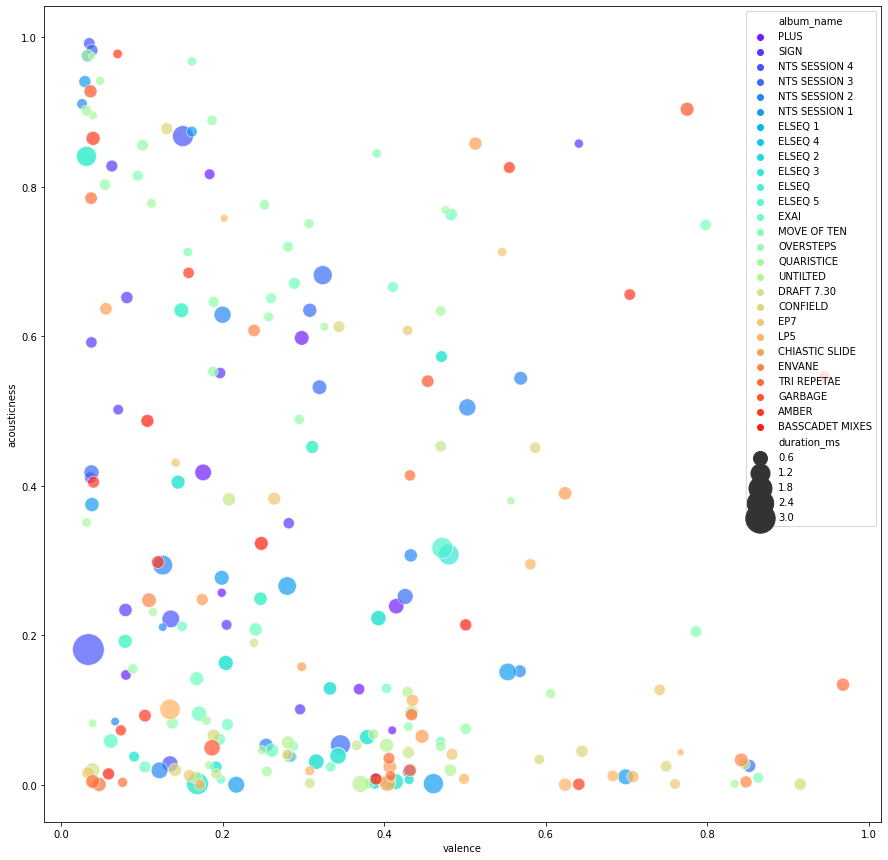

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# creating the figure
plt.figure(figsize=(15,15))

# defining the x and y axes
axes = sns.scatterplot(data=df, x='valence', y='acousticness', hue='album_name', palette='rainbow', size='duration_ms', sizes=(50, 1000), alpha=0.7)

# defining the legend so we can identify albums in the graph
h, labs = axes.get_legend_handles_labels()
axes.legend(h, labs, loc='best', title=None)

In [2]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# extracting the relevant columns from our original dataset to a numpy array
X = (
    df.filter(['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'tempo', 'valence'])
)

# standardising, normalising, 0db'ing the data to benefit the algorithm
Xs = StandardScaler().fit_transform(X)

NameError: name 'df' is not defined